In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
import sympy
from matplotlib import cm
from utils import is_extreme_boundary

### Load precomputed integrals

In [2]:
poisson_finctional = dill.load(
    open("../calculations/hermite_cubic_poisson_matrix", "rb")
)
integral_values = dill.load(
    open("../calculations/hermite_cubic_poisson_right_values", "rb")
)
basis = dill.load(open("../calculations/hermite_cubic_basis_transformed", "rb"))

### Initialize the domain

In [3]:
t = np.linspace(0 + np.pi / 4 * 0, 2 * np.pi + np.pi / 4 * 0, 7, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [4]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.03neo1")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]

print(f"Total number of points {points.shape[0]}")

Total number of points 85


### Visualize the triangulation

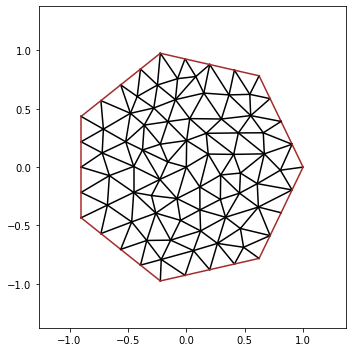

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis("equal")

cl = ["black", "brown"]

for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [7]:
x, y = sympy.symbols("x y", real=True)

In [8]:
right_part_values = np.zeros((points.shape[0], 3))

In [9]:
F = sympy.Float(1)
F_x = F.diff(x)
F_y = F.diff(y)

In [10]:
right_part_values[:, 0] = sympy.lambdify((x, y), F)(*points.T)
right_part_values[:, 1] = sympy.lambdify((x, y), F_x)(*points.T)
right_part_values[:, 2] = sympy.lambdify((x, y), F_y)(*points.T)

In [11]:
matrix = np.zeros((3 * points.shape[0], 3 * points.shape[0]))
b = np.zeros(3 * points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    right = right_part_values[element].flatten()

    FF = poisson_finctional(x1, y1, x2, y2, x3, y3)
    ff = integral_values(x1, y1, x2, y2, x3, y3, *right)

    for local_point in range(3):
        if vertex_marker_is_boundary[element[local_point]] == True:
            matrix[3 * element[local_point] + 0, 3 * element[local_point] + 0] = 1
            b[3 * element[local_point] + 0] = 0

            # check whether the boundary point is 'extreme'
            state, direction = is_extreme_boundary(
                edges, points, edge_marker_is_boundary, element[local_point]
            )

            if state == False:
                # handle the case when the tangential vector is parallel to x or y axes
                if np.isclose(direction[0], 0):
                    stiffness_idx = 0
                    condition_idx = 1
                    dx = stiffness_idx
                    dy = condition_idx
                elif np.isclose(direction[1], 0):
                    stiffness_idx = 1
                    condition_idx = 0
                    dx = stiffness_idx
                    dy = condition_idx
                else:
                    stiffness_idx = 0
                    condition_idx = 1
                    dx = 0
                    dy = 1

                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + stiffness_idx + 1,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + stiffness_idx + 1,
                                3 * other_point + other_degree,
                            ]
                        )

                matrix[
                    3 * element[local_point] + condition_idx + 1,
                    3 * element[local_point] + stiffness_idx + 1,
                ] = direction[dx]
                matrix[
                    3 * element[local_point] + condition_idx + 1,
                    3 * element[local_point] + condition_idx + 1,
                ] = direction[dy]

                b[3 * element[local_point] + stiffness_idx + 1] -= (
                    2 * ff[3 * local_point + stiffness_idx + 1]
                )
                b[3 * element[local_point] + condition_idx + 1] = 0

            else:
                matrix[3 * element[local_point] + 1, 3 * element[local_point] + 1] = 1
                matrix[3 * element[local_point] + 2, 3 * element[local_point] + 2] = 1
                b[3 * element[local_point] + 1] = 0
                b[3 * element[local_point] + 2] = 0

        else:
            for degree in range(3):
                for other_point in range(3):
                    for other_degree in range(3):
                        matrix[
                            3 * element[local_point] + degree,
                            3 * element[other_point] + other_degree,
                        ] += (
                            2
                            * FF[
                                3 * local_point + degree, 3 * other_point + other_degree
                            ]
                        )

            b[3 * element[local_point] + 0] -= 2 * ff[3 * local_point + 0]
            b[3 * element[local_point] + 1] -= 2 * ff[3 * local_point + 1]
            b[3 * element[local_point] + 2] -= 2 * ff[3 * local_point + 2]

100%|██████████| 140/140 [00:00<00:00, 590.20it/s]


In [12]:
c = np.linalg.solve(matrix, b)

In [13]:
U = -(1 - x**2 - y**2) / 4
U_x = sympy.lambdify((x, y), U.diff(x))(*points.T)
U_y = sympy.lambdify((x, y), U.diff(y))(*points.T)
U = sympy.lambdify((x, y), U)(*points.T)

In [14]:
F = c[0::3]
Fx = c[1::3]
Fy = c[2::3]

In [15]:
param = np.linspace(0, 1, 5)
tx, ty = np.meshgrid(param, param, indexing="ij")
mask = ty <= 1 - tx
tx = tx[mask]
ty = ty[mask]

In [16]:
X, Y, Z = [], [], []

for element in triangles:
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    ptx = x1 + tx * (x2 - x1) + ty * (x3 - x1)
    pty = y1 + tx * (y2 - y1) + ty * (y3 - y1)

    ptz = basis(
        x1,
        y1,
        x2,
        y2,
        x3,
        y3,
        F[element[0]],
        Fx[element[0]],
        Fy[element[0]],
        F[element[1]],
        Fx[element[1]],
        Fy[element[1]],
        F[element[2]],
        Fx[element[2]],
        Fy[element[2]],
        tx,
        ty,
    )

    X.append(ptx)
    Y.append(pty)
    Z.append(ptz)

X = np.concatenate(X)
Y = np.concatenate(Y)
Z = np.concatenate(Z)

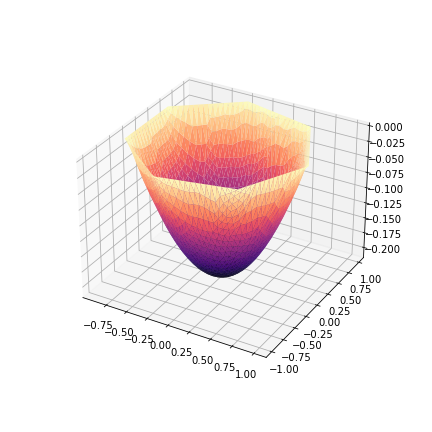

In [17]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection="3d"))
ax.plot_trisurf(X, Y, Z, cmap="magma")
plt.show()

In [18]:
err = (X**2 + Y**2 - 1) / 4 - Z
abs(err).mean()

0.03636964211143893